In [1]:
#Annual Rebalancing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from empyrical import max_drawdown
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

#yearly returns calculation
def yearly_returns(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) 
    returns = {}
    for year in range(1999, 2025): 
        start_date = f"{year-1}-12-31"
        end_date = f"{year}-12-31"
        start_price = df['Adj Close'].loc[:start_date].iloc[-1]
        end_price = df['Adj Close'].loc[:end_date].iloc[-1]
        yearly_return = (end_price - start_price) / start_price
        returns[year] = yearly_return
    return pd.Series(returns)

data = {
    'xlb': pd.read_csv("xlb_weekly_return_detailed.csv"),
    'xle': pd.read_csv("xle_weekly_return_detailed.csv"),
    'xlf': pd.read_csv("xlf_weekly_return_detailed.csv"),
    'xli': pd.read_csv("xli_weekly_return_detailed.csv"),
    'xlk': pd.read_csv("xlk_weekly_return_detailed.csv"),
    'xlp': pd.read_csv("xlp_weekly_return_detailed.csv"),
    'xlu': pd.read_csv("xlu_weekly_return_detailed.csv"),
    'xlv': pd.read_csv("xlv_weekly_return_detailed.csv"),
    'xly': pd.read_csv("xly_weekly_return_detailed.csv")
}

yearly_returns_dict = {key: yearly_returns(df) for key, df in data.items()}
final_df = pd.DataFrame(yearly_returns_dict)
final_df.index.name = 'Date'

cash_w = 100
cash_m = 100
cash_l = 100

cash_annual_w = []
cash_annual_m = []
cash_annual_l = []

#cash calculation
for year in range(1999, 2024):
    sorted_returns = final_df.loc[year].sort_values()
    first_three = sorted_returns.iloc[0:3]
    middle_three = sorted_returns.iloc[3:6]
    last_three = sorted_returns.iloc[6:9]
    next_year = year + 1
    if next_year in final_df.index:
        returns_next_year_w = final_df.loc[next_year][last_three.index]
        total_return_w = ((cash_w / 3) * (1 + returns_next_year_w)).sum()
        cash_w = total_return_w
        cash_annual_w.append((year + 1, cash_w))
        returns_next_year_m = final_df.loc[next_year][middle_three.index]
        total_return_m = ((cash_m / 3) * (1 + returns_next_year_m)).sum()
        cash_m = total_return_m
        cash_annual_m.append((year + 1, cash_m))
        returns_next_year_l = final_df.loc[next_year][first_three.index]
        total_return_l = ((cash_l / 3) * (1 + returns_next_year_l)).sum()
        cash_l = total_return_l
        cash_annual_l.append((year + 1, cash_l))

years_w, cash_values_w = zip(*cash_annual_w)
years_m, cash_values_m = zip(*cash_annual_m)
years_l, cash_values_l = zip(*cash_annual_l)

years = range(2000, 2025)
df1 = pd.DataFrame({'Year': years, 'Winners': cash_values_w})
df1["Median"]=cash_values_m
df1["Losers"]=cash_values_l

initial_value = 100
df1['Annualized_Return_Winners'] = (df1['Winners'] - df1['Winners'].shift(1, fill_value=initial_value)) / df1['Winners'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Median'] = (df1['Median'] - df1['Median'].shift(1, fill_value=initial_value)) / df1['Median'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Losers'] = (df1['Losers'] - df1['Losers'].shift(1, fill_value=initial_value)) / df1['Losers'].shift(1, fill_value=initial_value)*100

# daily returns dataframe
daily_returns_df = pd.DataFrame()

for etf, df in data.items():
    df = df.reset_index() 
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Return': etf}, inplace=True)
    if daily_returns_df.empty:
        daily_returns_df = df[['Date', etf]]
    else:
        daily_returns_df = pd.merge(daily_returns_df, df[['Date', etf]], on='Date', how='outer')

daily_returns_df.set_index('Date', inplace=True)

# dataframes for bottom, middle, and top ETFs
result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in range(1999, 2025):
    x = final_df.loc[date].sort_values()
    
    for i, group in enumerate(['bottom', 'middle', 'top']):
        selected = x.iloc[i*3:(i+1)*3]
        temp_df = pd.DataFrame({
            0: [selected.index[0]],
            1: [selected.index[1]],
            2: [selected.index[2]],
        }, index=[date])
        
        result_dfs[group] = pd.concat([result_dfs[group], temp_df])
# average daily returns for each group
final_result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for year in range(1999, 2025):
    for group in ['bottom', 'middle', 'top']:
        etfs = result_dfs[group].loc[year].values
        selected_returns = daily_returns_df[etfs]
        selected_returns_year = selected_returns[selected_returns.index.year == year+1]
        avg_daily_returns = selected_returns_year.mean(axis=1)
        final_result_dfs[group] = pd.concat([final_result_dfs[group], avg_daily_returns])
df1.set_index("Year", inplace=True)
for group in ['top', 'middle', 'bottom']:
    yearly_volatility = final_result_dfs[group].groupby(final_result_dfs[group].index.year).std() * np.sqrt(252)
    df1[group]=yearly_volatility[0]
df1.rename(columns={"bottom": "Volatility_Losers",
            "middle": "Volatility_Median",
            "top": "Volatility_Winners"}, inplace=True)
df1["Sharpe_Ratio_Winners"]=df1["Annualized_Return_Winners"]/df1["Volatility_Winners"]
df1["Sharpe_Ratio_Median"]=df1["Annualized_Return_Median"]/df1["Volatility_Median"]
df1["Sharpe_Ratio_Losers"]=df1["Annualized_Return_Losers"]/df1["Volatility_Losers"]
for group in ['bottom', 'middle', 'top']:
    final_result_dfs[group] = final_result_dfs[group] / 100
for group in ['top', 'middle', 'bottom']:
    mdd=final_result_dfs[group].groupby(final_result_dfs[group].index.year).apply(lambda x: max_drawdown(x))
    df1[group] = mdd*100
df1.rename(columns={"bottom": "MDD_Losers",
            "middle": "MDD_Median",
            "top": "MDD_Winners"}, inplace=True)
# max drawdown for each group
max_drawdowns = {}
for group in ['bottom', 'middle', 'top']:
    max_drawdowns[group] = max_drawdown(final_result_dfs[group])

# Extract only the values from the max_drawdowns dictionary and round to two decimal places
max_drawdowns_values_a = {group: round(float(value.iloc[0]), 2) for group, value in max_drawdowns.items()}

w_a_maxdd=max_drawdowns_values_a["top"]
m_a_maxdd=max_drawdowns_values_a["middle"]
l_a_maxdd=max_drawdowns_values_a["bottom"]

df2=pd.DataFrame()
df2=df1
df2.head(10)
#df1.to_csv("annual.csv")

,Winners,Median,Losers,Annualized_Return_Winners,Annualized_Return_Median,Annualized_Return_Losers,Volatility_Winners,Volatility_Median,Volatility_Losers,Sharpe_Ratio_Winners,Sharpe_Ratio_Median,Sharpe_Ratio_Losers,MDD_Winners,MDD_Median,MDD_Losers
Year,,,,,,,,,,,,,,,
2000,82.871786,98.593973,124.621875,-17.128214,-1.406027,24.621875,24.927977,20.209393,20.330556,-0.687108,-0.069573,1.211077,-22.433113,-15.807364,-15.453780
2001,72.520349,90.567271,121.095054,-12.490906,-8.141169,-2.830018,17.092723,18.894284,28.767439,-0.730773,-0.430880,-0.098376,-21.132925,-24.237302,-31.600621
2002,66.559485,72.601759,88.159401,-8.219574,-19.836650,-27.198182,24.868115,23.746856,28.943429,-0.330527,-0.835338,-0.939701,-25.582199,-30.206322,-41.308519
2003,83.894268,91.683613,116.692492,26.044047,26.282908,32.365341,14.380514,16.741819,17.402692,1.811065,1.569896,1.859789,-10.216686,-14.530958,-15.797138
2004,92.851056,107.640150,133.377219,10.676281,17.403914,14.298030,13.974891,10.569693,10.291529,0.763962,1.646586,1.389301,-10.449033,-7.501978,-6.421488
2005,111.197361,108.973287,137.353375,19.758855,1.238513,2.981136,14.225878,12.192347,9.221459,1.388937,0.101581,0.323282,-9.861757,-10.151520,-5.399806
2006,128.254494,127.746849,157.526004,15.339513,17.227673,14.686664,11.896861,10.903008,11.708423,1.289375,1.580084,1.254367,-6.278951,-8.539991,-11.221315
2007,122.083439,158.252591,176.487196,-4.811571,23.879839,12.036865,17.501179,17.540799,13.728212,-0.274928,1.361388,0.876798,-14.578162,-10.767502,-7.771427
2008,76.535090,108.025436,111.069885,-37.309195,-31.738599,-37.066322,45.028919,32.367357,44.452482,-0.828561,-0.980574,-0.833841,-49.421115,-40.993857,-50.264460


In [2]:
#Semi-Annual Rebalancing
import pandas as pd
import matplotlib.pyplot as plt

#returns calculation
def semi_annual_returns(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) 
    returns = {}
    for year in range(1999, 2025):
        start_date_1 = f"{year-1}-12-31"
        end_date_1 = f"{year}-06-30"
        start_price_1 = df['Adj Close'].loc[:start_date_1].iloc[-1]
        end_price_1 = df['Adj Close'].loc[:end_date_1].iloc[-1]
        half_year_return_1 = (end_price_1 - start_price_1) / start_price_1
        returns[f"{year}-01"] = half_year_return_1
        
        start_date_2 = f"{year}-06-30"
        end_date_2 = f"{year}-12-31"
        start_price_2 = df['Adj Close'].loc[:start_date_2].iloc[-1]
        end_price_2 = df['Adj Close'].loc[:end_date_2].iloc[-1]
        half_year_return_2 = (end_price_2 - start_price_2) / start_price_2
        returns[f"{year}-02"] = half_year_return_2
    
    return pd.Series(returns)

data = {
    'xlb': pd.read_csv("xlb_weekly_return_detailed.csv"),
    'xle': pd.read_csv("xle_weekly_return_detailed.csv"),
    'xlf': pd.read_csv("xlf_weekly_return_detailed.csv"),
    'xli': pd.read_csv("xli_weekly_return_detailed.csv"),
    'xlk': pd.read_csv("xlk_weekly_return_detailed.csv"),
    'xlp': pd.read_csv("xlp_weekly_return_detailed.csv"),
    'xlu': pd.read_csv("xlu_weekly_return_detailed.csv"),
    'xlv': pd.read_csv("xlv_weekly_return_detailed.csv"),
    'xly': pd.read_csv("xly_weekly_return_detailed.csv")
}

semi_annual_returns_dict = {key: semi_annual_returns(df) for key, df in data.items()}
final_df = pd.DataFrame(semi_annual_returns_dict)
final_df.index.name = 'Date'

cash_w = 100
cash_m = 100
cash_l = 100

cash_semi_annual_w = []
cash_semi_annual_m = []
cash_semi_annual_l = []

#cash calculation
for period in final_df.index[1:-1]:
    sorted_returns = final_df.loc[period].sort_values()
    first_three = sorted_returns.iloc[0:3]
    middle_three = sorted_returns.iloc[3:6]
    last_three = sorted_returns.iloc[6:9]
    next_period = final_df.index[final_df.index.get_loc(period) + 1]
    
    returns_next_period_w = final_df.loc[next_period][last_three.index]
    total_return_w = ((cash_w / 3) * (1 + returns_next_period_w)).sum()
    cash_w = total_return_w
    cash_semi_annual_w.append((next_period, cash_w))
    
    returns_next_period_m = final_df.loc[next_period][middle_three.index]
    total_return_m = ((cash_m / 3) * (1 + returns_next_period_m)).sum()
    cash_m = total_return_m
    cash_semi_annual_m.append((next_period, cash_m))
    
    returns_next_period_l = final_df.loc[next_period][first_three.index]
    total_return_l = ((cash_l / 3) * (1 + returns_next_period_l)).sum()
    cash_l = total_return_l
    cash_semi_annual_l.append((next_period, cash_l))

periods_w, cash_values_w = zip(*cash_semi_annual_w)
periods_m, cash_values_m = zip(*cash_semi_annual_m)
periods_l, cash_values_l = zip(*cash_semi_annual_l)
cash_values_w=cash_values_w[1::2]
cash_values_m=cash_values_m[1::2]
cash_values_l=cash_values_l[1::2]
years = range(2000, 2025)
df1 = pd.DataFrame({'Year': years, 'Winners': cash_values_w})
df1["Median"]=cash_values_m
df1["Losers"]=cash_values_l

initial_value = 100
df1['Annualized_Return_Winners'] = (df1['Winners'] - df1['Winners'].shift(1, fill_value=initial_value)) / df1['Winners'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Median'] = (df1['Median'] - df1['Median'].shift(1, fill_value=initial_value)) / df1['Median'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Losers'] = (df1['Losers'] - df1['Losers'].shift(1, fill_value=initial_value)) / df1['Losers'].shift(1, fill_value=initial_value)*100
# daily returns dataframe
daily_returns_df = pd.DataFrame()

for etf, df in data.items():
    df = df.reset_index() 
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Return': etf}, inplace=True)
    if daily_returns_df.empty:
        daily_returns_df = df[['Date', etf]]
    else:
        daily_returns_df = pd.merge(daily_returns_df, df[['Date', etf]], on='Date', how='outer')

daily_returns_df.set_index('Date', inplace=True)

# dataframes for bottom, middle, and top ETFs
result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[1:]:
    x = final_df.loc[date].sort_values()
    
    for i, group in enumerate(['bottom', 'middle', 'top']):
        selected = x.iloc[i*3:(i+1)*3]
        temp_df = pd.DataFrame({
            0: [selected.index[0]],
            1: [selected.index[1]],
            2: [selected.index[2]],
        }, index=[date])
        
        result_dfs[group] = pd.concat([result_dfs[group], temp_df])


# average daily returns for each group
final_result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[1:]:
    year, half = int(date[:4]), int(date[-1])
    
    if half == 1:
        current_date = pd.Timestamp(year=year, month=1, day=1)
        next_half_start = pd.Timestamp(year=year, month=7, day=1)
        next_half_end = pd.Timestamp(year=year, month=12, day=31)
    else:
        current_date = pd.Timestamp(year=year, month=7, day=1)
        next_half_start = pd.Timestamp(year=year+1, month=1, day=1)
        next_half_end = pd.Timestamp(year=year+1, month=6, day=30)
    
    for group in ['bottom', 'middle', 'top']:
        etfs = result_dfs[group].loc[date].values
        selected_returns = daily_returns_df[etfs]
        
        # Ensure that the end date does not exceed the dataset's available date range
        next_half_end = min(next_half_end, daily_returns_df.index[-1])
        
        # Select returns for the calculated period
        selected_returns_period = selected_returns.loc[next_half_start:next_half_end]
        avg_daily_returns = selected_returns_period.mean(axis=1)
        
        # average daily returns concatenation
        final_result_dfs[group] = pd.concat([final_result_dfs[group], avg_daily_returns])
df1.set_index("Year", inplace=True)
for group in ['top', 'middle', 'bottom']:
    yearly_volatility = final_result_dfs[group].groupby(final_result_dfs[group].index.year).std() * np.sqrt(252)
    df1[group]=yearly_volatility[0]
df1.rename(columns={"bottom": "Volatility_Losers",
            "middle": "Volatility_Median",
            "top": "Volatility_Winners"}, inplace=True)
df1["Sharpe_Ratio_Winners"]=df1["Annualized_Return_Winners"]/df1["Volatility_Winners"]
df1["Sharpe_Ratio_Median"]=df1["Annualized_Return_Median"]/df1["Volatility_Median"]
df1["Sharpe_Ratio_Losers"]=df1["Annualized_Return_Losers"]/df1["Volatility_Losers"]
for group in ['bottom', 'middle', 'top']:
    final_result_dfs[group] = final_result_dfs[group] / 100
for group in ['top', 'middle', 'bottom']:
    mdd=final_result_dfs[group].groupby(final_result_dfs[group].index.year).apply(lambda x: max_drawdown(x))
    df1[group] = mdd*100
df1.rename(columns={"bottom": "MDD_Losers",
            "middle": "MDD_Median",
            "top": "MDD_Winners"}, inplace=True)
# max drawdown for each group
max_drawdowns = {}
for group in ['bottom', 'middle', 'top']:
    max_drawdowns[group] = max_drawdown(final_result_dfs[group])

# Extract only the values from the max_drawdowns dictionary and round to two decimal places
max_drawdowns_values_sa = {group: round(float(value), 2) if isinstance(value, (float, np.float64)) else round(float(value.iloc[0]), 2) for group, value in max_drawdowns.items()}

w_sa_maxdd = max_drawdowns_values_sa["top"]
m_sa_maxdd = max_drawdowns_values_sa["middle"]
l_sa_maxdd = max_drawdowns_values_sa["bottom"]

df3=pd.DataFrame()
df3=df1
df3.head(10)
#df1.to_csv("semiannual.csv")

,Winners,Median,Losers,Annualized_Return_Winners,Annualized_Return_Median,Annualized_Return_Losers,Volatility_Winners,Volatility_Median,Volatility_Losers,Sharpe_Ratio_Winners,Sharpe_Ratio_Median,Sharpe_Ratio_Losers,MDD_Winners,MDD_Median,MDD_Losers
Year,,,,,,,,,,,,,,,
2000,108.214195,92.427272,104.866560,8.214195,-7.572728,4.866560,21.803609,22.106454,23.138323,0.376736,-0.342557,0.210325,-14.592660,-18.672388,-16.703010
2001,98.023358,83.423551,99.887547,-9.417283,-9.741412,-4.747951,20.916078,19.508329,26.287042,-0.450241,-0.499346,-0.180619,-28.269975,-26.567457,-26.162692
2002,86.156231,69.801580,73.540669,-12.106428,-16.328687,-26.376540,24.287644,24.652002,29.180859,-0.498460,-0.662368,-0.903899,-29.065390,-27.285351,-42.049985
2003,108.295262,86.345365,99.746194,25.696379,23.701161,35.634059,16.670302,17.345070,14.467732,1.541447,1.366449,2.463002,-12.949528,-16.276844,-11.467755
2004,121.921990,99.865040,113.616739,12.582940,15.657674,13.905839,13.014653,11.294581,11.093766,0.966829,1.386300,1.253482,-9.052603,-7.128519,-10.417014
2005,142.197837,101.605302,119.680187,16.630180,1.742613,5.336756,14.870220,10.670760,10.484351,1.118355,0.163307,0.509021,-10.185214,-9.214357,-8.997511
2006,163.430945,119.114676,137.941284,14.932090,17.232737,15.258246,15.377184,9.282506,10.055563,0.971055,1.856475,1.517394,-12.764652,-7.589966,-6.960984
2007,187.974327,134.165985,140.108848,15.017585,12.635982,1.571367,18.806910,14.062918,16.146390,0.798514,0.898532,0.097320,-12.530408,-7.052952,-13.107564
2008,115.861133,97.099102,83.885481,-38.363321,-27.627631,-40.128349,43.634246,34.331763,43.635639,-0.879202,-0.804725,-0.919623,-48.653938,-41.133282,-50.141690


In [3]:
# Quarterly Rebalancing

import pandas as pd
import matplotlib.pyplot as plt

#returns calculations
def quarterly_returns(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) 
    returns = {}
    for year in range(1999, 2025):
        
        start_date_1 = f"{year-1}-12-31"
        end_date_1 = f"{year}-03-31"
        start_price_1 = df['Adj Close'].loc[:start_date_1].iloc[-1]
        end_price_1 = df['Adj Close'].loc[:end_date_1].iloc[-1]
        quarter_return_1 = (end_price_1 - start_price_1) / start_price_1
        returns[f"{year}-Q1"] = quarter_return_1
        
        start_date_2 = f"{year}-03-31"
        end_date_2 = f"{year}-06-30"
        start_price_2 = df['Adj Close'].loc[:start_date_2].iloc[-1]
        end_price_2 = df['Adj Close'].loc[:end_date_2].iloc[-1]
        quarter_return_2 = (end_price_2 - start_price_2) / start_price_2
        returns[f"{year}-Q2"] = quarter_return_2
        
        start_date_3 = f"{year}-06-30"
        end_date_3 = f"{year}-09-30"
        start_price_3 = df['Adj Close'].loc[:start_date_3].iloc[-1]
        end_price_3 = df['Adj Close'].loc[:end_date_3].iloc[-1]
        quarter_return_3 = (end_price_3 - start_price_3) / start_price_3
        returns[f"{year}-Q3"] = quarter_return_3
        
        start_date_4 = f"{year}-09-30"
        end_date_4 = f"{year}-12-31"
        start_price_4 = df['Adj Close'].loc[:start_date_4].iloc[-1]
        end_price_4 = df['Adj Close'].loc[:end_date_4].iloc[-1]
        quarter_return_4 = (end_price_4 - start_price_4) / start_price_4
        returns[f"{year}-Q4"] = quarter_return_4
    
    return pd.Series(returns)

data = {
    'xlb': pd.read_csv("xlb_weekly_return_detailed.csv"),
    'xle': pd.read_csv("xle_weekly_return_detailed.csv"),
    'xlf': pd.read_csv("xlf_weekly_return_detailed.csv"),
    'xli': pd.read_csv("xli_weekly_return_detailed.csv"),
    'xlk': pd.read_csv("xlk_weekly_return_detailed.csv"),
    'xlp': pd.read_csv("xlp_weekly_return_detailed.csv"),
    'xlu': pd.read_csv("xlu_weekly_return_detailed.csv"),
    'xlv': pd.read_csv("xlv_weekly_return_detailed.csv"),
    'xly': pd.read_csv("xly_weekly_return_detailed.csv")
}
quarterly_returns_dict = {key: quarterly_returns(df) for key, df in data.items()}
final_df = pd.DataFrame(quarterly_returns_dict)
final_df.index.name = 'Date'

cash_w = 100
cash_m = 100
cash_l = 100

cash_quarterly_w = []
cash_quarterly_m = []
cash_quarterly_l = []

#cash calculations
for period in final_df.index[3:-1]:
    sorted_returns = final_df.loc[period].sort_values()
    first_three = sorted_returns.iloc[0:3]
    middle_three = sorted_returns.iloc[3:6]
    last_three = sorted_returns.iloc[6:9]
    next_period = final_df.index[final_df.index.get_loc(period) + 1]
    
    returns_next_period_w = final_df.loc[next_period][last_three.index]
    total_return_w = ((cash_w / 3) * (1 + returns_next_period_w)).sum()
    cash_w = total_return_w
    cash_quarterly_w.append((next_period, cash_w))
    
    returns_next_period_m = final_df.loc[next_period][middle_three.index]
    total_return_m = ((cash_m / 3) * (1 + returns_next_period_m)).sum()
    cash_m = total_return_m
    cash_quarterly_m.append((next_period, cash_m))
    
    returns_next_period_l = final_df.loc[next_period][first_three.index]
    total_return_l = ((cash_l / 3) * (1 + returns_next_period_l)).sum()
    cash_l = total_return_l
    cash_quarterly_l.append((next_period, cash_l))

periods_w, cash_values_w = zip(*cash_quarterly_w)
periods_m, cash_values_m = zip(*cash_quarterly_m)
periods_l, cash_values_l = zip(*cash_quarterly_l)
cash_values_w=cash_values_w[3::4]
cash_values_m=cash_values_m[3::4]
cash_values_l=cash_values_l[3::4]
years = range(2000, 2025)
df1 = pd.DataFrame({'Year': years, 'Winners': cash_values_w,"Median":cash_values_m,"Losers":cash_values_l})

initial_value = 100
df1['Annualized_Return_Winners'] = (df1['Winners'] - df1['Winners'].shift(1, fill_value=initial_value)) / df1['Winners'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Median'] = (df1['Median'] - df1['Median'].shift(1, fill_value=initial_value)) / df1['Median'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Losers'] = (df1['Losers'] - df1['Losers'].shift(1, fill_value=initial_value)) / df1['Losers'].shift(1, fill_value=initial_value)*100

# daily returns dataframe
daily_returns_df = pd.DataFrame()

for etf, df in data.items():
    df = df.reset_index() 
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Return': etf}, inplace=True)
    if daily_returns_df.empty:
        daily_returns_df = df[['Date', etf]]
    else:
        daily_returns_df = pd.merge(daily_returns_df, df[['Date', etf]], on='Date', how='outer')

daily_returns_df.set_index('Date', inplace=True)

# dataframes for bottom, middle, and top ETFs
result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[3:]:
    x = final_df.loc[date].sort_values()
    
    for i, group in enumerate(['bottom', 'middle', 'top']):
        selected = x.iloc[i*3:(i+1)*3]
        temp_df = pd.DataFrame({
            0: [selected.index[0]],
            1: [selected.index[1]],
            2: [selected.index[2]],
        }, index=[date])
        
        result_dfs[group] = pd.concat([result_dfs[group], temp_df])
# average daily returns for each group
final_result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

# function to get the start and end date of the next quarter
def get_next_quarter_dates(date_str):
    # Extract the year and quarter from the input string (e.g., '2001Q1')
    year = int(date_str[:4])
    quarter = int(date_str[-1])
    
    # start and end dates for the next quarter
    if quarter == 1:
        start_date = f"{year}-04-01"
        end_date = f"{year}-06-30"
    elif quarter == 2:
        start_date = f"{year}-07-01"
        end_date = f"{year}-09-30"
    elif quarter == 3:
        start_date = f"{year}-10-01"
        end_date = f"{year}-12-31"
    else:  # If it's Q4, the next quarter is Q1 of the next year
        start_date = f"{year+1}-01-01"
        end_date = f"{year+1}-03-31"
    
    return start_date, end_date

for date in final_df.index[3:]:
    # next quarter dates
    start_date, end_date = get_next_quarter_dates(date)
    
    for group in ['bottom', 'middle', 'top']:
        etfs = result_dfs[group].loc[date].values
        selected_returns = daily_returns_df[etfs]
        selected_returns_period = selected_returns.loc[start_date:end_date]
        avg_daily_returns = selected_returns_period.mean(axis=1)
        final_result_dfs[group] = pd.concat([final_result_dfs[group], avg_daily_returns])
df1.set_index("Year", inplace=True)
for group in ['top', 'middle', 'bottom']:
    yearly_volatility = final_result_dfs[group].groupby(final_result_dfs[group].index.year).std() * np.sqrt(252)
    df1[group]=yearly_volatility[0]
df1.rename(columns={"bottom": "Volatility_Losers",
            "middle": "Volatility_Median",
            "top": "Volatility_Winners"}, inplace=True)
df1["Sharpe_Ratio_Winners"]=df1["Annualized_Return_Winners"]/df1["Volatility_Winners"]
df1["Sharpe_Ratio_Median"]=df1["Annualized_Return_Median"]/df1["Volatility_Median"]
df1["Sharpe_Ratio_Losers"]=df1["Annualized_Return_Losers"]/df1["Volatility_Losers"]
for group in ['bottom', 'middle', 'top']:
    final_result_dfs[group] = final_result_dfs[group] / 100
for group in ['top', 'middle', 'bottom']:
    mdd=final_result_dfs[group].groupby(final_result_dfs[group].index.year).apply(lambda x: max_drawdown(x))
    df1[group] = mdd*100
df1.rename(columns={"bottom": "MDD_Losers",
            "middle": "MDD_Median",
            "top": "MDD_Winners"}, inplace=True)
# max drawdown for each group
max_drawdowns = {}
for group in ['bottom', 'middle', 'top']:
    max_drawdowns[group] = max_drawdown(final_result_dfs[group])

# Extract only the values from the max_drawdowns dictionary and round to two decimal places
max_drawdowns_values_q = {group: round(float(value.iloc[0]), 2) for group, value in max_drawdowns.items()}

w_quar_maxdd=max_drawdowns_values_q["top"]
m_quar_maxdd=max_drawdowns_values_q["middle"]
l_quar_maxdd=max_drawdowns_values_q["bottom"]
df4=pd.DataFrame()
df4=df1
df4.head(10)
#df1.to_csv("quarterly.csv")

,Winners,Median,Losers,Annualized_Return_Winners,Annualized_Return_Median,Annualized_Return_Losers,Volatility_Winners,Volatility_Median,Volatility_Losers,Sharpe_Ratio_Winners,Sharpe_Ratio_Median,Sharpe_Ratio_Losers,MDD_Winners,MDD_Median,MDD_Losers
Year,,,,,,,,,,,,,,,
2000,111.100793,107.941824,86.241586,11.100793,7.941824,-13.758414,20.884686,20.976248,24.568892,0.531528,0.378610,-0.559993,-11.269409,-18.525281,-25.632545
2001,87.446317,99.782816,93.513084,-21.291006,-7.558709,8.431545,19.013225,23.622406,23.865844,-1.119800,-0.319980,0.353289,-30.025783,-29.338465,-21.197474
2002,70.812058,83.484568,74.168138,-19.022253,-16.333722,-20.686887,24.613597,25.746973,27.805416,-0.772835,-0.634394,-0.743988,-28.718903,-30.964804,-39.633682
2003,91.019601,114.707179,88.228288,28.536868,37.399260,18.957130,18.297345,15.328437,15.052355,1.559618,2.439861,1.259413,-17.250446,-10.093322,-13.116687
2004,107.421572,120.587754,105.249819,18.020263,5.126597,19.292600,12.651813,11.774295,11.410467,1.424323,0.435406,1.690781,-6.582251,-11.789218,-7.942664
2005,105.149680,136.548451,119.072514,-2.114931,13.235753,13.133224,13.864194,10.389777,11.255054,-0.152546,1.273921,1.166874,-11.102714,-6.399977,-7.578763
2006,121.404109,150.132811,146.123264,15.458372,9.948380,22.717880,13.143214,11.320465,11.246890,1.176149,0.878796,2.019925,-13.512409,-9.291343,-5.744388
2007,145.205171,167.395131,143.575302,19.604824,11.498033,-1.743708,17.956519,15.189949,15.985890,1.091794,0.756950,-0.109078,-10.102350,-11.151550,-13.270974
2008,82.912432,120.318773,93.527460,-42.899807,-28.122895,-34.858253,36.835107,36.555356,48.136550,-1.164645,-0.769324,-0.724154,-52.290981,-42.975869,-43.356290


In [4]:
#Monthly Rebalancing

import pandas as pd
import matplotlib.pyplot as plt
from calendar import monthrange

#return calculation
def monthly_returns(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) 
    returns = {}
    for year in range(1999, 2025):
        for month in range(1, 13):
            start_date = pd.Timestamp(year=year, month=month, day=1) - pd.Timedelta(days=1)
            end_date = pd.Timestamp(year=year, month=month, day=monthrange(year, month)[1])
            
            start_price = df['Adj Close'].loc[:start_date].iloc[-1]
            end_price = df['Adj Close'].loc[:end_date].iloc[-1]
            month_return = (end_price - start_price) / start_price
            returns[f"{year}-{month:02d}"] = month_return
    
    return pd.Series(returns)

data = {
    'xlb': pd.read_csv("xlb_weekly_return_detailed.csv"),
    'xle': pd.read_csv("xle_weekly_return_detailed.csv"),
    'xlf': pd.read_csv("xlf_weekly_return_detailed.csv"),
    'xli': pd.read_csv("xli_weekly_return_detailed.csv"),
    'xlk': pd.read_csv("xlk_weekly_return_detailed.csv"),
    'xlp': pd.read_csv("xlp_weekly_return_detailed.csv"),
    'xlu': pd.read_csv("xlu_weekly_return_detailed.csv"),
    'xlv': pd.read_csv("xlv_weekly_return_detailed.csv"),
    'xly': pd.read_csv("xly_weekly_return_detailed.csv")
}

monthly_returns_dict = {key: monthly_returns(df) for key, df in data.items()}
final_df = pd.DataFrame(monthly_returns_dict)
final_df.index.name = 'Date'

cash_w = 100
cash_m = 100
cash_l = 100

cash_monthly_w = []
cash_monthly_m = []
cash_monthly_l = []

#cash calculation
for period in final_df.index[11:-1]:
    sorted_returns = final_df.loc[period].sort_values()
    first_three = sorted_returns.iloc[0:3]
    middle_three = sorted_returns.iloc[3:6]
    last_three = sorted_returns.iloc[6:9]
    next_period = final_df.index[final_df.index.get_loc(period) + 1]
    
    returns_next_period_w = final_df.loc[next_period][last_three.index]
    total_return_w = ((cash_w / 3) * (1 + returns_next_period_w)).sum()
    cash_w = total_return_w
    cash_monthly_w.append((next_period, cash_w))
    
    returns_next_period_m = final_df.loc[next_period][middle_three.index]
    total_return_m = ((cash_m / 3) * (1 + returns_next_period_m)).sum()
    cash_m = total_return_m
    cash_monthly_m.append((next_period, cash_m))
    
    returns_next_period_l = final_df.loc[next_period][first_three.index]
    total_return_l = ((cash_l / 3) * (1 + returns_next_period_l)).sum()
    cash_l = total_return_l
    cash_monthly_l.append((next_period, cash_l))

periods_w, cash_values_w = zip(*cash_monthly_w)
periods_m, cash_values_m = zip(*cash_monthly_m)
periods_l, cash_values_l = zip(*cash_monthly_l)
cash_values_w=cash_values_w[11::12]
cash_values_m=cash_values_m[11::12]
cash_values_l=cash_values_l[11::12]
years = range(2000, 2025)
df1 = pd.DataFrame({'Year': years, 'Winners': cash_values_w,"Median":cash_values_m,"Losers":cash_values_l})
initial_value = 100
df1['Annualized_Return_Winners'] = (df1['Winners'] - df1['Winners'].shift(1, fill_value=initial_value)) / df1['Winners'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Median'] = (df1['Median'] - df1['Median'].shift(1, fill_value=initial_value)) / df1['Median'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Losers'] = (df1['Losers'] - df1['Losers'].shift(1, fill_value=initial_value)) / df1['Losers'].shift(1, fill_value=initial_value)*100

# daily returns dataframe
daily_returns_df = pd.DataFrame()

for etf, df in data.items():
    df = df.reset_index() 
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Return': etf}, inplace=True)
    if daily_returns_df.empty:
        daily_returns_df = df[['Date', etf]]
    else:
        daily_returns_df = pd.merge(daily_returns_df, df[['Date', etf]], on='Date', how='outer')

daily_returns_df.set_index('Date', inplace=True)

# dataframes for bottom, middle, and top ETFs
result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[11:]:
    x = final_df.loc[date].sort_values()
    
    for i, group in enumerate(['bottom', 'middle', 'top']):
        selected = x.iloc[i*3:(i+1)*3]
        temp_df = pd.DataFrame({
            0: [selected.index[0]],
            1: [selected.index[1]],
            2: [selected.index[2]],
        }, index=[date])
        
        result_dfs[group] = pd.concat([result_dfs[group], temp_df])

# average daily returns for each group
final_result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[11:]:
    year, month = map(int, date.split('-'))
    
    # Determine the next month and year
    next_month = month + 1
    next_year = year
    if next_month > 12:
        next_month = 1
        next_year += 1
    
    # Define start and end dates for the next month
    start_date = pd.Timestamp(year=next_year, month=next_month, day=1)
    end_date = pd.Timestamp(year=next_year, month=next_month, day=monthrange(next_year, next_month)[1])
    
    for group in ['bottom', 'middle', 'top']:
        etfs = result_dfs[group].loc[date].values
        selected_returns = daily_returns_df[etfs]
        selected_returns_period = selected_returns.loc[start_date:end_date]
        avg_daily_returns = selected_returns_period.mean(axis=1)
        final_result_dfs[group] = pd.concat([final_result_dfs[group], avg_daily_returns])
df1.set_index("Year", inplace=True)
for group in ['top', 'middle', 'bottom']:
    yearly_volatility = final_result_dfs[group].groupby(final_result_dfs[group].index.year).std() * np.sqrt(252)
    df1[group]=yearly_volatility[0]
df1.rename(columns={"bottom": "Volatility_Losers",
            "middle": "Volatility_Median",
            "top": "Volatility_Winners"}, inplace=True)
df1["Sharpe_Ratio_Winners"]=df1["Annualized_Return_Winners"]/df1["Volatility_Winners"]
df1["Sharpe_Ratio_Median"]=df1["Annualized_Return_Median"]/df1["Volatility_Median"]
df1["Sharpe_Ratio_Losers"]=df1["Annualized_Return_Losers"]/df1["Volatility_Losers"]
for group in ['bottom', 'middle', 'top']:
    final_result_dfs[group] = final_result_dfs[group] / 100
for group in ['top', 'middle', 'bottom']:
    mdd=final_result_dfs[group].groupby(final_result_dfs[group].index.year).apply(lambda x: max_drawdown(x))
    df1[group] = mdd*100
df1.rename(columns={"bottom": "MDD_Losers",
            "middle": "MDD_Median",
            "top": "MDD_Winners"}, inplace=True)

# max drawdown for each group
max_drawdowns = {}
for group in ['bottom', 'middle', 'top']:
    max_drawdowns[group] = max_drawdown(final_result_dfs[group])

# Extract only the values from the max_drawdowns dictionary and round to two decimal places
max_drawdowns_values_m = {group: round(float(value.iloc[0]), 2) for group, value in max_drawdowns.items()}
w_mon_maxdd=max_drawdowns_values_m["top"]
m_mon_maxdd=max_drawdowns_values_m["middle"]
l_mon_maxdd=max_drawdowns_values_m["bottom"]

df5=pd.DataFrame()
df5=df1
df5.head(10)
#df1.to_csv("monthly.csv")

,Winners,Median,Losers,Annualized_Return_Winners,Annualized_Return_Median,Annualized_Return_Losers,Volatility_Winners,Volatility_Median,Volatility_Losers,Sharpe_Ratio_Winners,Sharpe_Ratio_Median,Sharpe_Ratio_Losers,MDD_Winners,MDD_Median,MDD_Losers
Year,,,,,,,,,,,,,,,
2000,93.298914,121.949049,89.334109,-6.701086,21.949049,-10.665891,19.389216,20.311946,24.767102,-0.345609,1.080598,-0.430648,-21.287368,-11.977847,-16.159122
2001,73.181771,125.306947,88.420831,-21.562034,2.753525,-1.022317,21.419179,19.554099,25.453263,-1.006669,0.140816,-0.040164,-30.841515,-18.647691,-29.458020
2002,59.761691,96.439259,75.828554,-18.338009,-23.037580,-14.241302,24.750578,27.304029,26.993247,-0.740912,-0.843743,-0.527588,-28.242594,-35.976552,-35.960403
2003,71.444113,123.336537,104.884195,19.548345,27.890382,38.317547,16.086921,15.906203,16.906965,1.215170,1.753428,2.266376,-14.177079,-11.124082,-15.579188
2004,77.730472,145.947234,120.807594,8.798988,18.332522,15.181885,11.466317,11.546745,12.202703,0.767377,1.587679,1.244141,-6.269989,-7.768423,-8.598419
2005,84.371599,165.204839,122.893974,8.543789,13.194910,1.727028,12.956179,11.000312,11.902041,0.659437,1.199503,0.145103,-9.966732,-7.348901,-9.142044
2006,97.834805,191.211347,143.044233,15.957036,15.741977,16.396458,11.962399,10.742139,12.521864,1.333933,1.465442,1.309426,-8.679664,-8.041314,-8.101833
2007,109.922368,230.699687,137.969258,12.355074,20.651672,-3.547836,16.106895,15.220307,17.749176,0.767067,1.356850,-0.199887,-10.102350,-8.881441,-14.848301
2008,68.699353,153.390387,88.089824,-37.501935,-33.510796,-36.152571,33.578287,36.713216,50.800758,-1.116851,-0.912772,-0.711654,-42.050487,-45.894605,-53.498245


In [5]:
# Weekly Rebalancing

import pandas as pd

#returns calculation
def calculate_weekly_returns(data):
    def calculate_weekly_return(r1, r2):
        return (r2 - r1) / r1

    results = {}

    for name, df in data.items():
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date')
        df['Year_Week'] = df['Date'].dt.strftime('%Y-%U')

        weekly_returns = []
        r1 = df[df['Year_Week'] == '1998-52']['Adj Close'].iloc[-1]

        for week in df[df['Date'].dt.year >= 1999]['Year_Week'].unique():
            if week in df['Year_Week'].values:
                r2 = df[df['Year_Week'] == week]['Adj Close'].iloc[-1]
                weekly_return = calculate_weekly_return(r1, r2)
                weekly_returns.append((week, weekly_return))
                r1 = r2
            else:
                weekly_returns.append((week, None))

        results[name] = pd.DataFrame(weekly_returns, columns=['Year_Week', 'Weekly_Return'])

    return results

data = {
    'xlb': pd.read_csv("xlb_weekly_return_detailed.csv"),
    'xle': pd.read_csv("xle_weekly_return_detailed.csv"),
    'xlf': pd.read_csv("xlf_weekly_return_detailed.csv"),
    'xli': pd.read_csv("xli_weekly_return_detailed.csv"),
    'xlk': pd.read_csv("xlk_weekly_return_detailed.csv"),
    'xlp': pd.read_csv("xlp_weekly_return_detailed.csv"),
    'xlu': pd.read_csv("xlu_weekly_return_detailed.csv"),
    'xlv': pd.read_csv("xlv_weekly_return_detailed.csv"),
    'xly': pd.read_csv("xly_weekly_return_detailed.csv")
}

weekly_returns_dict = calculate_weekly_returns(data)

# DataFrame creation
final_df = pd.DataFrame({key: df['Weekly_Return'] for key, df in weekly_returns_dict.items()})
final_df.index = weekly_returns_dict[list(weekly_returns_dict.keys())[0]]['Year_Week']
final_df.index.name = 'Date'
cash_w = 100
cash_m = 100
cash_l = 100

cash_weekly_w = []
cash_weekly_m = []
cash_weekly_l = []

#cash calcultion
for period in final_df.index[51:-1]:
    sorted_returns = final_df.loc[period].sort_values()
    first_three = sorted_returns.iloc[0:3]
    middle_three = sorted_returns.iloc[3:6]
    last_three = sorted_returns.iloc[6:9]
    next_period = final_df.index[final_df.index.get_loc(period) + 1]
    
    returns_next_period_w = final_df.loc[next_period][last_three.index]
    total_return_w = ((cash_w / 3) * (1 + returns_next_period_w)).sum()
    cash_w = total_return_w
    cash_weekly_w.append((next_period, cash_w))
    
    returns_next_period_m = final_df.loc[next_period][middle_three.index]
    total_return_m = ((cash_m / 3) * (1 + returns_next_period_m)).sum()
    cash_m = total_return_m
    cash_weekly_m.append((next_period, cash_m))
    
    returns_next_period_l = final_df.loc[next_period][first_three.index]
    total_return_l = ((cash_l / 3) * (1 + returns_next_period_l)).sum()
    cash_l = total_return_l
    cash_weekly_l.append((next_period, cash_l))
def get_last_values_per_year(cash):
    last_values = {}
    for week, value in cash:
        year = week[:4]
        week_number = int(week[5:])        
        if year not in last_values or week_number > last_values[year][0]:
            last_values[year] = (week_number, value)
    result = [(year, value[1]) for year, value in last_values.items()]
    return sorted(result)  # Sort by year
last_values_w = get_last_values_per_year(cash_weekly_w) 
last_values_m = get_last_values_per_year(cash_weekly_m) 
last_values_l = get_last_values_per_year(cash_weekly_l) 
periods_w, cash_values_w = zip(*last_values_w)
periods_m, cash_values_m = zip(*last_values_m)
periods_l, cash_values_l = zip(*last_values_l)
years = range(2000, 2025)
df1 = pd.DataFrame({'Year': years, 'Winners': cash_values_w,"Median":cash_values_m,"Losers":cash_values_l})
initial_value = 100
df1['Annualized_Return_Winners'] = (df1['Winners'] - df1['Winners'].shift(1, fill_value=initial_value)) / df1['Winners'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Median'] = (df1['Median'] - df1['Median'].shift(1, fill_value=initial_value)) / df1['Median'].shift(1, fill_value=initial_value)*100
df1['Annualized_Return_Losers'] = (df1['Losers'] - df1['Losers'].shift(1, fill_value=initial_value)) / df1['Losers'].shift(1, fill_value=initial_value)*100
daily_returns_df = pd.DataFrame()

for etf, df in data.items():
    df = df.reset_index() 
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Return': etf}, inplace=True)
    if daily_returns_df.empty:
        daily_returns_df = df[['Date',"Year_Week", etf]]
    else:
        daily_returns_df = pd.merge(daily_returns_df, df[['Date', etf]], on='Date', how='outer')

daily_returns_df.set_index('Date', inplace=True)

# dataframes for bottom, middle, and top ETFs
result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}

for date in final_df.index[51:]:
    x = final_df.loc[date].sort_values()
    
    for i, group in enumerate(['bottom', 'middle', 'top']):
        selected = x.iloc[i*3:(i+1)*3]
        temp_df = pd.DataFrame({
            0: [selected.index[0]],
            1: [selected.index[1]],
            2: [selected.index[2]],
        }, index=[date])
        
        result_dfs[group] = pd.concat([result_dfs[group], temp_df])
# Calculate average daily returns for each group
final_result_dfs = {
    'bottom': pd.DataFrame(),
    'middle': pd.DataFrame(),
    'top': pd.DataFrame()
}
def get_next_week(year_week):
    year, week = map(int, year_week.split('-'))
    if week == 52:
        if f"{year}-53" in final_df.index:
            return f"{year}-53"
        elif f"{year+1}-00" in final_df.index:
            return f"{year+1}-00"
        else:
            return f"{year+1}-01"
    elif week == 53:
        if f"{year+1}-00" in final_df.index:
            return f"{year+1}-00"
        else:
            return f"{year+1}-01"
    else:
        return f"{year}-{week+1:02d}"

for date in final_df.index[51:]:
    for group in ['bottom', 'middle', 'top']:
        etfs = result_dfs[group].loc[date].values
        selected_returns = daily_returns_df[etfs]
        selected_returns["Year_Week"]=daily_returns_df["Year_Week"]
        next_week = get_next_week(date)
        selected_returns_period = selected_returns[selected_returns["Year_Week"] == next_week]
        # Calculate average returns, excluding the 'Year_Week' column
        avg_daily_returns = selected_returns_period.drop('Year_Week', axis=1).mean(axis=1)
        # Concatenate the calculated average daily returns
        final_result_dfs[group] = pd.concat([final_result_dfs[group], avg_daily_returns])
df1.set_index("Year", inplace=True)
for group in ['top', 'middle', 'bottom']:
    yearly_volatility = final_result_dfs[group].groupby(final_result_dfs[group].index.year).std() * np.sqrt(252)
    df1[group]=yearly_volatility[0]
df1.rename(columns={"bottom": "Volatility_Losers",
            "middle": "Volatility_Median",
            "top": "Volatility_Winners"}, inplace=True)
df1["Sharpe_Ratio_Winners"]=df1["Annualized_Return_Winners"]/df1["Volatility_Winners"]
df1["Sharpe_Ratio_Median"]=df1["Annualized_Return_Median"]/df1["Volatility_Median"]
df1["Sharpe_Ratio_Losers"]=df1["Annualized_Return_Losers"]/df1["Volatility_Losers"]
for group in ['bottom', 'middle', 'top']:
    final_result_dfs[group] = final_result_dfs[group] / 100
for group in ['top', 'middle', 'bottom']:
    mdd=final_result_dfs[group].groupby(final_result_dfs[group].index.year).apply(lambda x: max_drawdown(x))
    df1[group] = mdd*100
df1.rename(columns={"bottom": "MDD_Losers",
            "middle": "MDD_Median",
            "top": "MDD_Winners"}, inplace=True)

# max drawdown for each group
max_drawdowns = {}
for group in ['bottom', 'middle', 'top']:
    max_drawdowns[group] = max_drawdown(final_result_dfs[group])

# Extract only the values from the max_drawdowns dictionary and round to two decimal places
max_drawdowns_values_w = {group: round(float(value.iloc[0]), 2) for group, value in max_drawdowns.items()}
w_week_maxdd = max_drawdowns_values_w["top"]
m_week_maxdd = max_drawdowns_values_w["middle"]
l_week_maxdd = max_drawdowns_values_w["bottom"]

df6=pd.DataFrame()
df6=df1
df6.head(10)
df6.to_csv("weekly.csv")

In [6]:
#SPY buy and hold
import pandas as pd
import numpy as np
from empyrical import max_drawdown
import matplotlib.pyplot as plt

def yearly_returns(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) 
    returns = {}
    for year in range(1999, 2025): 
        start_date = f"{year-1}-12-31"
        end_date = f"{year}-12-31"
        start_price = df['Adj Close'].loc[:start_date].iloc[-1]
        end_price = df['Adj Close'].loc[:end_date].iloc[-1]
        yearly_return = (end_price - start_price) / start_price
        returns[year] = yearly_return
    return pd.Series(returns)

data = {
    'spy': pd.read_csv("spy_weekly_return_detailed.csv"),
}

yearly_returns_dict = {key: yearly_returns(df) for key, df in data.items()}
final_df = pd.DataFrame(yearly_returns_dict)
final_df.index.name = 'Date'

cash_annual_bh = []
cash_bh = 100
for year in range(2000, 2025):
    total_returns_bh = cash_bh * (1 + final_df.loc[year])
    cash_bh=total_returns_bh
    cash_annual_bh.append((year, total_returns_bh))

years_w, cash_values_bh = zip(*cash_annual_bh)
data=cash_annual_bh
years = [item[0] for item in data]
values = [item[1]['spy'] for item in data]

df1 = pd.DataFrame({'Year': years, 'Value': values})
initial_value = 100
df1['Annualized_Return'] = (df1['Value'] - df1['Value'].shift(1, fill_value=initial_value)) / df1['Value'].shift(1, fill_value=initial_value)*100


df=pd.read_csv("spy_weekly_return_detailed.csv")
df=df[df["Year"]>=2000]

yearly_volatility = df.groupby('Year')['Return'].std() * np.sqrt(252)

df1 = df1.merge(yearly_volatility.rename('Yearly_Volatility'), on='Year', how='left')

df1["Sharpe_Ratio"]=df1["Annualized_Return"]/df1["Yearly_Volatility"]
df1.set_index("Year",inplace=True)
df["Return"]=df["Return"]/100
yearly_max_drawdown = df.groupby("Year")["Return"].apply(lambda x: max_drawdown(x))
df1["Max_drawdown"]=yearly_max_drawdown*100
bh_a_maxdd = bh_sa_maxdd=bh_quar_maxdd=bh_mon_maxdd=bh_week_maxdd=max_drawdown(df["Return"])

df7=pd.DataFrame()
df7=df1
#df0.to_csv("spy_bh.csv")
df7


,Value,Annualized_Return,Yearly_Volatility,Sharpe_Ratio,Max_drawdown
Year,,,,,
2000,90.257451,-9.742549,23.901580,-0.407611,-17.132712
2001,79.649610,-11.752870,22.081960,-0.532239,-28.809004
2002,62.450593,-21.593348,26.451373,-0.816341,-32.970460
2003,80.055550,28.190216,16.531463,1.705246,-13.729520
2004,88.623010,10.701895,11.133220,0.961258,-7.522956
2005,92.896058,4.821601,10.323624,0.467045,-6.955329
2006,107.616708,15.846366,10.006819,1.583557,-7.590777
2007,113.150304,5.141950,15.911134,0.323167,-9.932327
2008,71.520137,-36.791918,41.282325,-0.891227,-47.574736


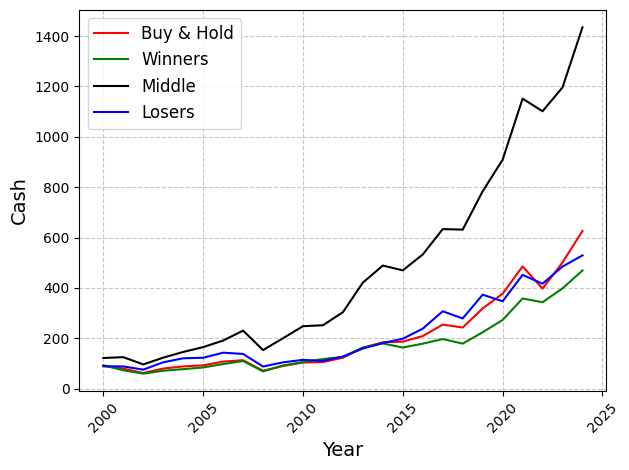

In [7]:
# Monthly Growth Curve
import matplotlib.pyplot as plt

years = range(2000, 2025)
plt.plot(years, df7['Value'], label='Buy & Hold', color='RED')
plt.plot(years, df5['Winners'], label='Winners',color="GREEN")
plt.plot(years, df5['Median'], label='Middle', color="BLACK")
plt.plot(years, df5['Losers'], label='Losers', color="BLUE") 

#plt.title('Cash Values Over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Cash', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

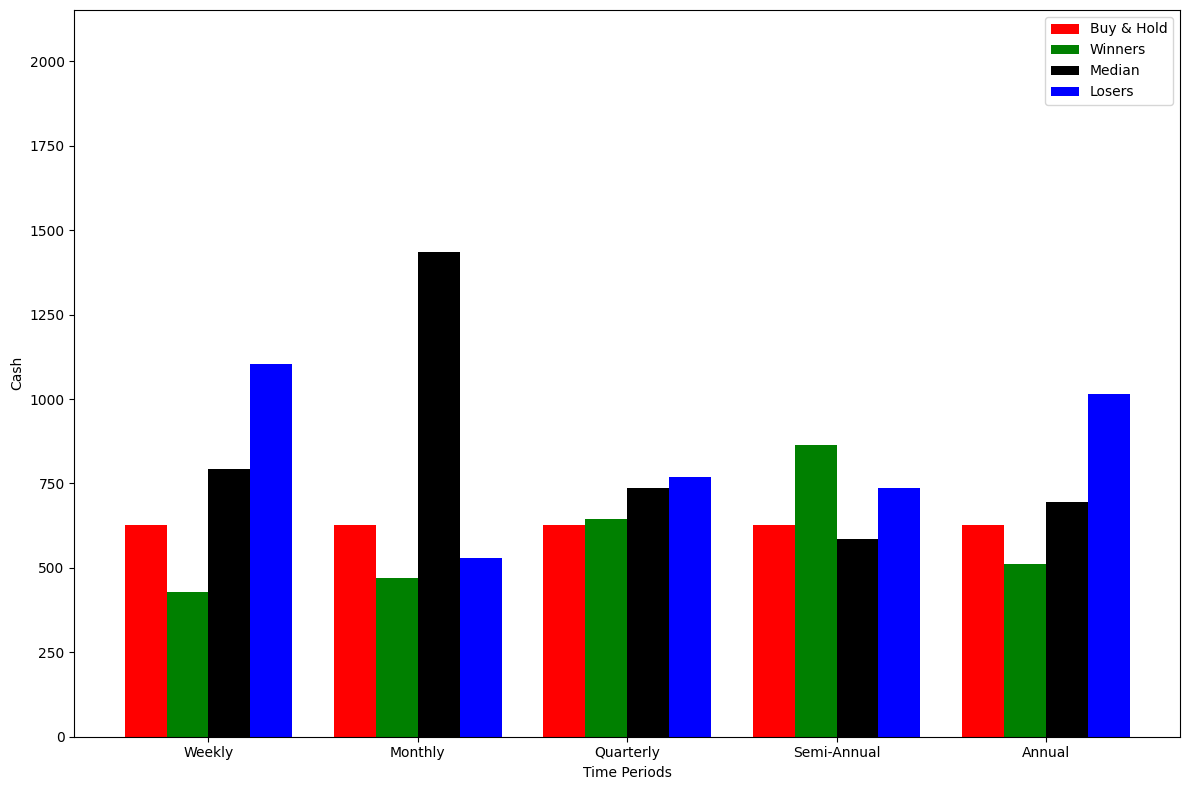

In [8]:
import matplotlib.pyplot as plt
import numpy as np


bh_values = [df7["Value"].iloc[-1],df7["Value"].iloc[-1],df7["Value"].iloc[-1],df7["Value"].iloc[-1],df7["Value"].iloc[-1]]
w_values = [df6["Winners"].iloc[-1],df5["Winners"].iloc[-1],df4["Winners"].iloc[-1],df3["Winners"].iloc[-1],df2["Winners"].iloc[-1]]
l_values = [df6["Losers"].iloc[-1],df5["Losers"].iloc[-1],df4["Losers"].iloc[-1],df3["Losers"].iloc[-1],df2["Losers"].iloc[-1]]
m_values = [df6["Median"].iloc[-1],df5["Median"].iloc[-1],df4["Median"].iloc[-1],df3["Median"].iloc[-1],df2["Median"].iloc[-1]]

categories = ["Weekly", 'Monthly','Quarterly', 'Semi-Annual', 'Annual']
labels = ['Buy & Hold', 'Winners', 'Median', 'Losers']

n_categories = len(categories)

x = np.arange(n_categories)

width = 0.2

plt.figure(figsize=(12, 8))

bars_bh = plt.bar(x - 1.5*width, bh_values, width, label='Buy & Hold', color='red')
bars_w = plt.bar(x - 0.5*width, w_values, width, label='Winners', color='green')
bars_m = plt.bar(x + 0.5*width, m_values, width, label='Median', color='black')
bars_l = plt.bar(x + 1.5*width, l_values, width, label='Losers', color='blue')


plt.xlabel('Time Periods')
plt.ylabel('Cash')
#plt.title('Cash Values by Category and Time Period')
plt.xticks(x, categories)
plt.legend()

def add_value_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

max_value = max(max(bh_values), max(w_values), max(l_values), max(m_values))
plt.ylim(0, max_value * 1.5) 

plt.tight_layout()
plt.show()


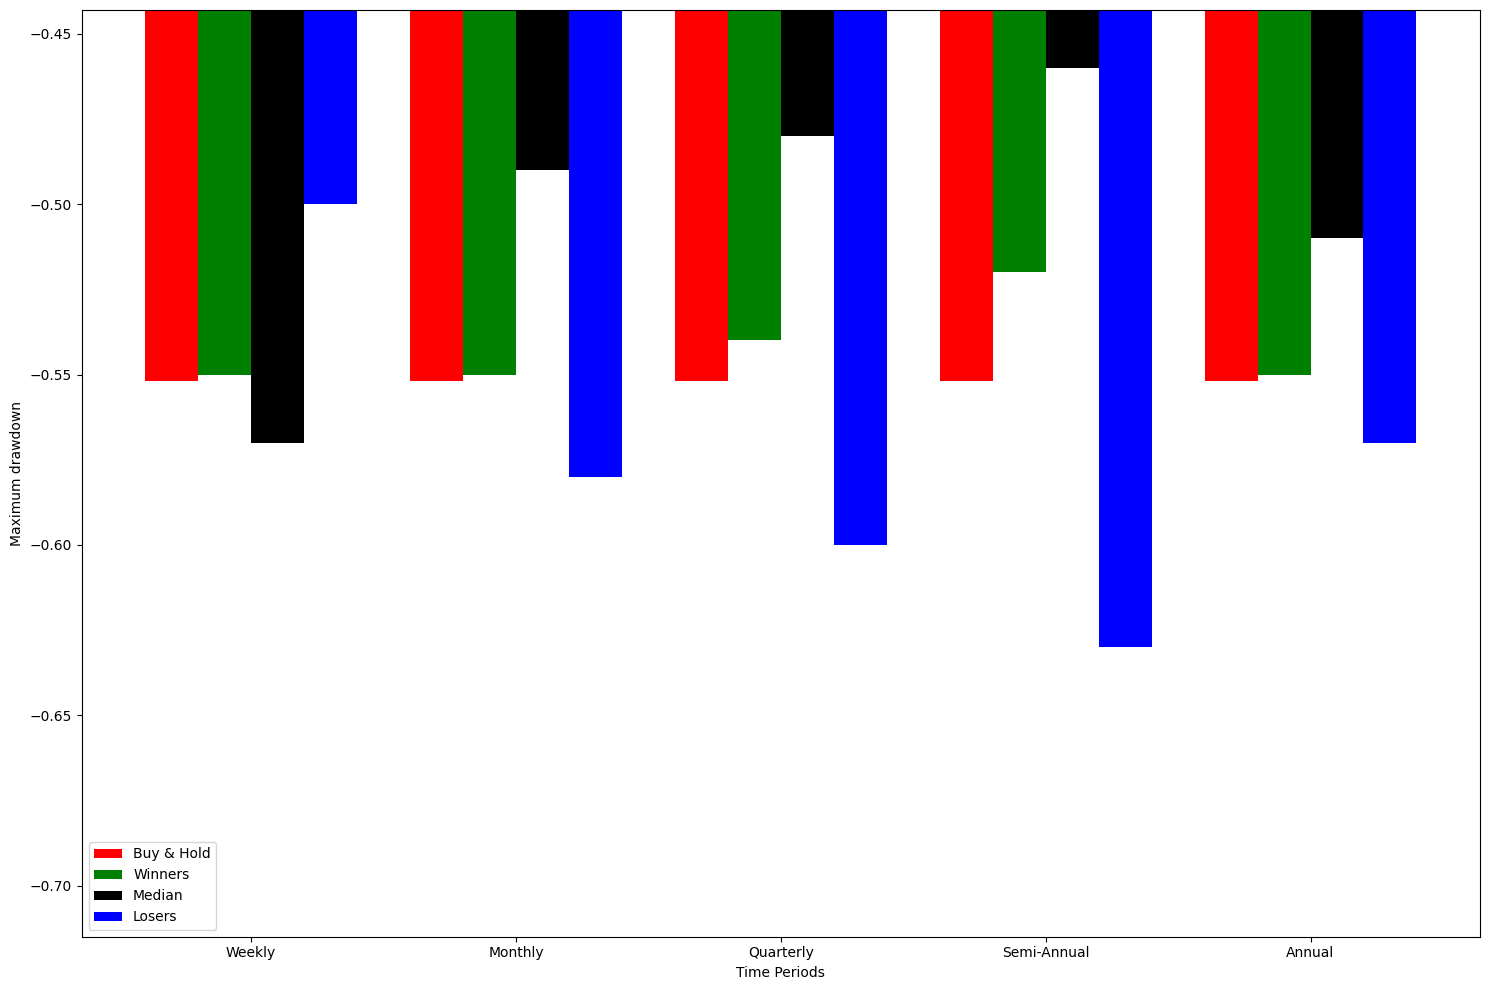

In [9]:
import matplotlib.pyplot as plt
import numpy as np

bh_values = [bh_week_maxdd,bh_mon_maxdd,bh_quar_maxdd,bh_sa_maxdd,bh_a_maxdd]
w_values = [w_week_maxdd,w_mon_maxdd,w_quar_maxdd,w_sa_maxdd,w_a_maxdd]
l_values = [l_week_maxdd,l_mon_maxdd,l_quar_maxdd,l_sa_maxdd,l_a_maxdd]
m_values = [m_week_maxdd,m_mon_maxdd,m_quar_maxdd,m_sa_maxdd,m_a_maxdd]

categories = ["Weekly",'Monthly','Quarterly', 'Semi-Annual', 'Annual']
labels = ['Buy & Hold', 'Winners', 'Median', 'Losers']


n_categories = len(categories)

x = np.arange(n_categories)

width = 0.2

plt.figure(figsize=(15, 10))

bars_bh = plt.bar(x - 1.5*width, bh_values, width, label='Buy & Hold', color='red')
bars_w = plt.bar(x - 0.5*width, w_values, width, label='Winners', color='green')
bars_m = plt.bar(x + 0.5*width, m_values, width, label='Median', color='black')
bars_l = plt.bar(x + 1.5*width, l_values, width, label='Losers', color='blue')



plt.xlabel('Time Periods')
plt.ylabel('Maximum drawdown')
#plt.title('Cash Values by Category and Time Period')
plt.xticks(x, categories)
plt.legend()


# Adjust y-scale to increase negative direction
y_min = min(min(bh_values), min(w_values), min(l_values), min(m_values))
y_max = max(max(bh_values), max(w_values), max(l_values), max(m_values))
y_range = y_max - y_min

# Extend the lower limit further into the negative
plt.ylim(y_min - 0.5 * y_range, y_max + 0.1 * y_range)



def add_value_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='top')

plt.tight_layout()
plt.show()